# EV Charging Load Modeling

This notebook explores EV Charging Load Modeling and Prediction. It It develops the following models: 

- Bayesian linear model using PyMC
- Random Forest model using scikit-learn
- TODO: Gaussian Process Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import numpy as np
from sklearn.model_selection import train_test_split
import holidays

import os
import glob

In [2]:
RANDOM_SEED=4

In [3]:
sns.set_theme()

## Charging Data

In [4]:
raw_data = pd.read_csv("../data/Electric_Vehicle_Charging_Station_Data.csv")

In [5]:
raw_data

,ObjectId2,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID
0,1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/1/2018 17:49,MDT,1/1/2018 19:52,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0
1,2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 8:52,MDT,1/2/2018 9:16,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1
2,3,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 21:11,MDT,1/3/2018 6:23,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2
3,4,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,1/3/2018 9:19,MDT,1/3/2018 11:14,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3
4,5,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,1/3/2018 14:13,MDT,1/3/2018 14:30,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70189,70190,MUNICIPAL SC / 1100WALNUT1,1100 Walnut,Boulder,Colorado,80302,2023-08-31 09:20:52,MDT,2023-08-31 10:56:11,MDT,01:35:13,00:49:39,2.360,1.675,0.296,Level 2,70125
70190,70191,MUNICIPAL SC / 1104 SPRUCE1,1100 Spruce St,Boulder,Colorado,80302,2023-08-31 09:24:16,MDT,2023-08-31 10:26:58,MDT,01:02:42,01:02:28,6.277,4.457,0.788,Level 2,70126
70191,70192,BOULDER / ATRIUM ST1,1770 13th St,Boulder,Colorado,80302,2023-08-31 09:39:36,MDT,2023-08-31 11:48:55,MDT,02:09:22,02:09:08,12.933,9.183,1.623,Level 2,70127
70192,70193,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2023-08-31 09:41:08,MDT,2023-08-31 10:55:27,MDT,01:14:21,01:14:09,7.512,5.334,0.943,Level 2,70128


In [6]:
raw_data.describe()

,ObjectId2,Zip_Postal_Code,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,ObjectID
count,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000
mean,35097.500000,80302.573724,8.450916,5.258133,1.060591,35096.500000
std,20263.406735,1.108910,8.807785,5.919214,1.105376,20263.406735
min,1.000000,80301.000000,0.000000,0.000000,0.000000,0.000000
25%,17549.250000,80302.000000,2.842250,1.597000,0.357000,17548.250000
50%,35097.500000,80302.000000,6.240000,3.676500,0.783000,35096.500000
75%,52645.750000,80303.000000,11.373000,6.851000,1.427000,52644.750000
max,70194.000000,80305.000000,92.691000,65.811000,11.633000,70193.000000


In [7]:
raw_data.columns

Index(['ObjectId2', 'Station_Name', 'Address', 'City', 'State_Province',
       'Zip_Postal_Code', 'Start_Date___Time', 'Start_Time_Zone',
       'End_Date___Time', 'End_Time_Zone', 'Total_Duration__hh_mm_ss_',
       'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'GHG_Savings__kg_',
       'Gasoline_Savings__gallons_', 'Port_Type', 'ObjectID'],
      dtype='object')

In [8]:
df = raw_data.copy()

# Convert your start and end times to datetime, ensuring correct timezone handling if necessary
df['Start_Date___Time'] = pd.to_datetime(df['Start_Date___Time'], format='mixed')
df['End_Date___Time'] = pd.to_datetime(df['End_Date___Time'], format='mixed')

display(df.isnull().sum())

df = df.dropna()

ObjectId2                     0
Station_Name                  0
Address                       0
City                          0
State_Province                0
Zip_Postal_Code               0
Start_Date___Time             0
Start_Time_Zone               0
End_Date___Time               2
End_Time_Zone                 0
Total_Duration__hh_mm_ss_     0
Charging_Time__hh_mm_ss_      0
Energy__kWh_                  0
GHG_Savings__kg_              0
Gasoline_Savings__gallons_    0
Port_Type                     0
ObjectID                      0
dtype: int64

In [9]:
# Function to distribute charging session energy hourly
def distribute_energy_hourly(row):
    # Generate a date range for each hour the charging session covers
    start_hour = row['Start_Date___Time'].floor('H')
    end_hour = (row['End_Date___Time'] + pd.Timedelta(hours=1)).floor('H')
    hours = pd.date_range(start=start_hour, end=end_hour, freq='H')

    total_hours = (row['End_Date___Time'] - row['Start_Date___Time']).total_seconds() / 3600.0
    energy_per_hour = row['Energy__kWh_'] / total_hours if total_hours else 0 
    hourly_data = pd.DataFrame({'hour_date': hours[:-1], 'kWh': energy_per_hour})

    # The last hour energy may not be a full hour
    if hours.size > 1:
        last_hour_fraction = (row['End_Date___Time'] - hours[-2]).total_seconds() / 3600.0
        hourly_data.loc[hourly_data.index[-1], 'kWh'] *= last_hour_fraction
    
    # If there is only one hour, adjust energy based on the portion of the hour during which charging occurred
    if hours.size == 1:
        only_hour_fraction = (row['End_Date___Time'] - row['Start_Date___Time']).total_seconds() / 3600.0
        hourly_data.loc[0, 'kWh'] = row['Energy__kWh_'] * only_hour_fraction
    
    return hourly_data

In [10]:
# Apply the function to each row and concatenate the results
hourly_contributions = pd.concat([distribute_energy_hourly(row) for index, row in df.iterrows()], ignore_index=True)
# Group by the hour and sum up the energy for that hour
hourly_energy_demand = hourly_contributions.groupby(hourly_contributions['hour_date']).sum().reset_index()

hourly_energy_demand["hour"] = hourly_energy_demand["hour_date"].dt.hour
hourly_energy_demand["day"] = hourly_energy_demand["hour_date"].dt.dayofweek
hourly_energy_demand["month"] = hourly_energy_demand["hour_date"].dt.month
hourly_energy_demand["year"] = hourly_energy_demand["hour_date"].dt.year
year_idx, years = pd.factorize(hourly_energy_demand["year"])
hourly_energy_demand["year_idx"] = year_idx

hourly_energy_demand.set_index('hour_date', inplace=True)

hourly_energy_demand

,kWh,hour,day,month,year,year_idx
hour_date,,,,,,
2018-01-01 17:00:00,3.172683,17,0,1,2018,0
2018-01-01 18:00:00,3.172683,18,0,1,2018,0
2018-01-01 19:00:00,2.749659,19,0,1,2018,0
2018-01-02 08:00:00,6.202500,8,1,1,2018,0
2018-01-02 09:00:00,1.654000,9,1,1,2018,0
...,...,...,...,...,...,...
2023-09-05 11:00:00,0.021090,11,1,9,2023,5
2023-09-05 12:00:00,0.021090,12,1,9,2023,5
2023-09-05 13:00:00,0.021090,13,1,9,2023,5


## Weather Data

In [11]:
directory = '../data/weather_data'
file_pattern = os.path.join(directory, '*.csv')

processed_dataframes = []

# Loop over all CSV files
for file_path in glob.glob(file_pattern):
    # Read the CSV file, skipping the first two rows
    data = pd.read_csv(file_path, skiprows=2)

    processed_data = data[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Relative Humidity']]
    
    processed_data.rename(columns={'Year': 'year', 
                                   'Month': 'month', 
                                   'Day': 'day', 
                                   'Hour': 'hour', 
                                   'Minute': 'minute', 
                                   'Temperature': 'temperature', 
                                   'Relative Humidity': 'relative_humidity'}, inplace=True)

    processed_data['datetime'] = pd.to_datetime(processed_data[['year', 'month', 'day', 'hour', 'minute']])
    processed_data.set_index('datetime', inplace=True)
    hourly_data = processed_data.resample('H').mean()
    hourly_data.reset_index(inplace=True)
    hourly_data = hourly_data[['datetime', 'temperature', 'relative_humidity']].copy()
 
    processed_dataframes.append(hourly_data)

temp_data = pd.concat(processed_dataframes)
temp_data.set_index('datetime', inplace=True)
temp_data = temp_data.dropna()

## Train/Test Split

In [12]:
us_holidays = holidays.US()
X = pd.merge(hourly_energy_demand, temp_data, left_index=True, right_index=True, how="inner")
X["kWh_std"] = (X["kWh"] - X["kWh"].mean()) / X["kWh"].std()
X["temperature_std"] = (X["temperature"] - X["temperature"].mean()) / X["temperature"].std()
X["is_holiday"] = pd.Series([x in us_holidays and 1 or 0 for x in X.index], index=X.index)

X = X[X.index.year == 2022]

X

,kWh,hour,day,month,year,year_idx,temperature,relative_humidity,kWh_std,temperature_std,is_holiday
2022-01-01 07:00:00,9.732944,7,5,1,2022,4,-9.9,70.95,-0.236013,-1.807742,1
2022-01-01 08:00:00,12.008143,8,5,1,2022,4,-10.3,69.96,-0.079665,-1.842578,1
2022-01-01 09:00:00,7.795581,9,5,1,2022,4,-10.9,69.90,-0.369145,-1.894832,1
2022-01-01 10:00:00,16.882521,10,5,1,2022,4,-11.4,69.57,0.255293,-1.938377,1
2022-01-01 11:00:00,13.429794,11,5,1,2022,4,-12.0,69.17,0.018028,-1.990632,1
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,7.805257,19,5,12,2022,4,8.1,54.29,-0.368480,-0.240120,0
2022-12-31 20:00:00,3.031893,20,5,12,2022,4,7.8,55.93,-0.696497,-0.266247,0
2022-12-31 21:00:00,5.833388,21,5,12,2022,4,6.7,64.28,-0.503984,-0.362046,0
2022-12-31 22:00:00,5.833388,22,5,12,2022,4,4.5,71.26,-0.503984,-0.553644,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X[["hour", "temperature", "day", "month", "temperature_std", "is_holiday"]], X.kWh, shuffle=False)

## Exploratory Data Analysis (EDA)

Text(0, 0.5, 'Count')

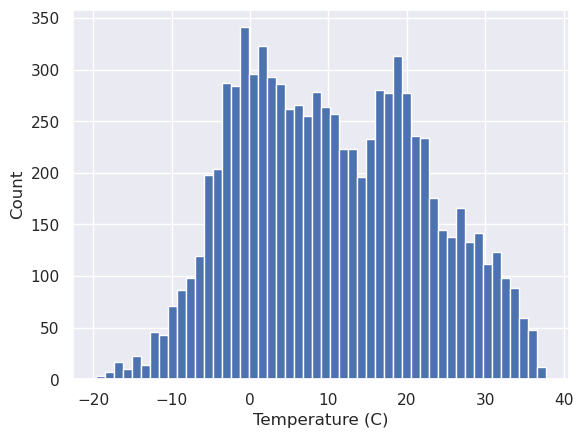

In [14]:
fig, ax = plt.subplots()

ax.hist(X.temperature, bins=50)
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Count")

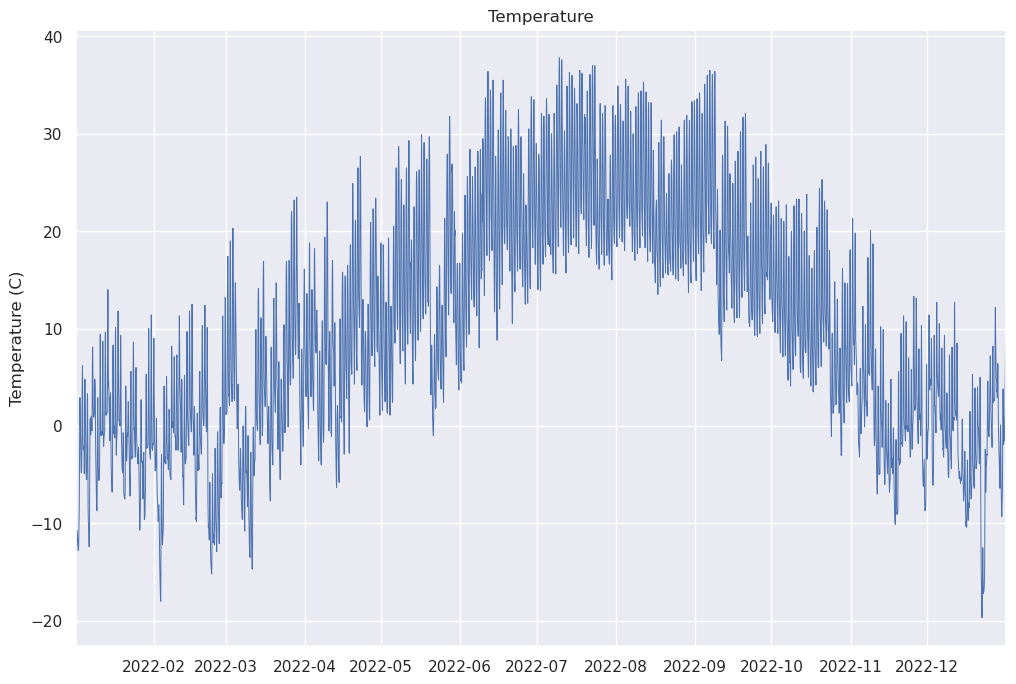

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X.index, X.temperature, linewidth=.7)

ax.set_title("Temperature")
ax.set_ylabel("Temperature (C)")
ax.set_xmargin(0)

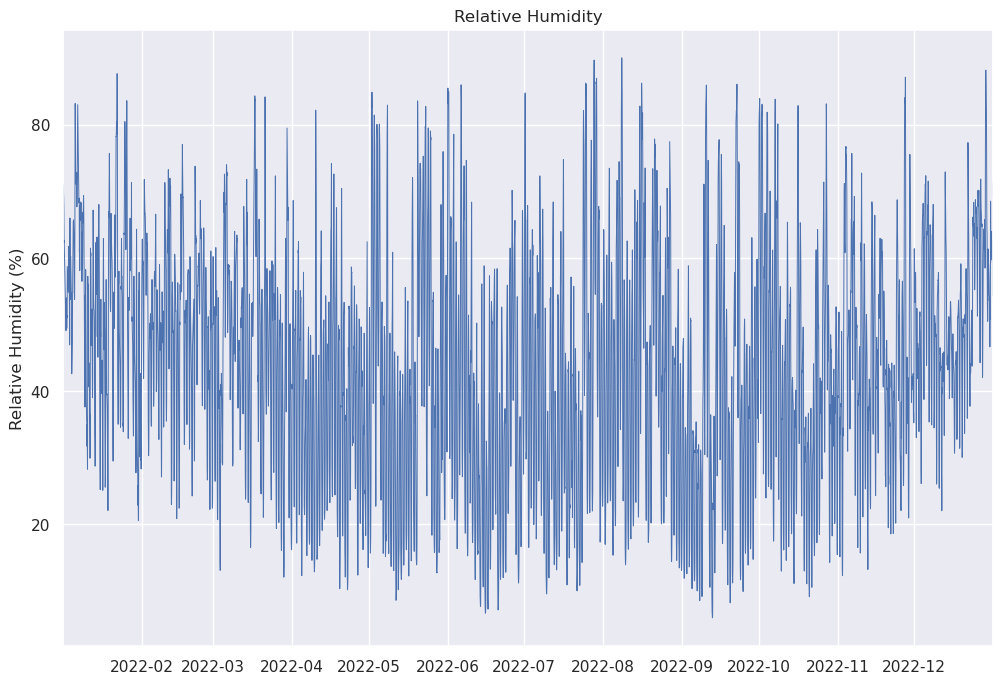

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X.index, X.relative_humidity, linewidth=.7)

ax.set_title("Relative Humidity")
ax.set_ylabel("Relative Humidity (%)")
ax.set_xmargin(0)

Text(0, 0.5, 'Count')

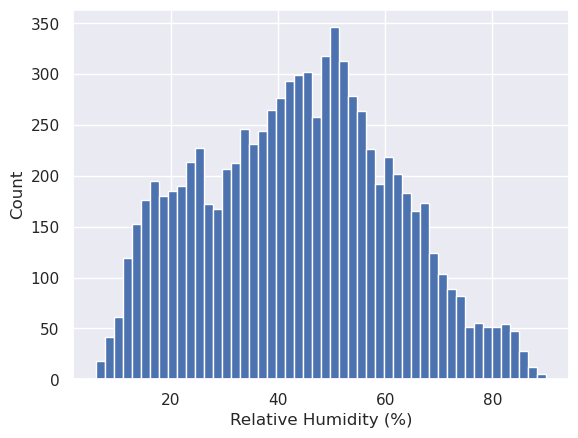

In [17]:
fig, ax = plt.subplots()

ax.hist(X.relative_humidity, bins=50)
ax.set_xlabel("Relative Humidity (%)")
ax.set_ylabel("Count")

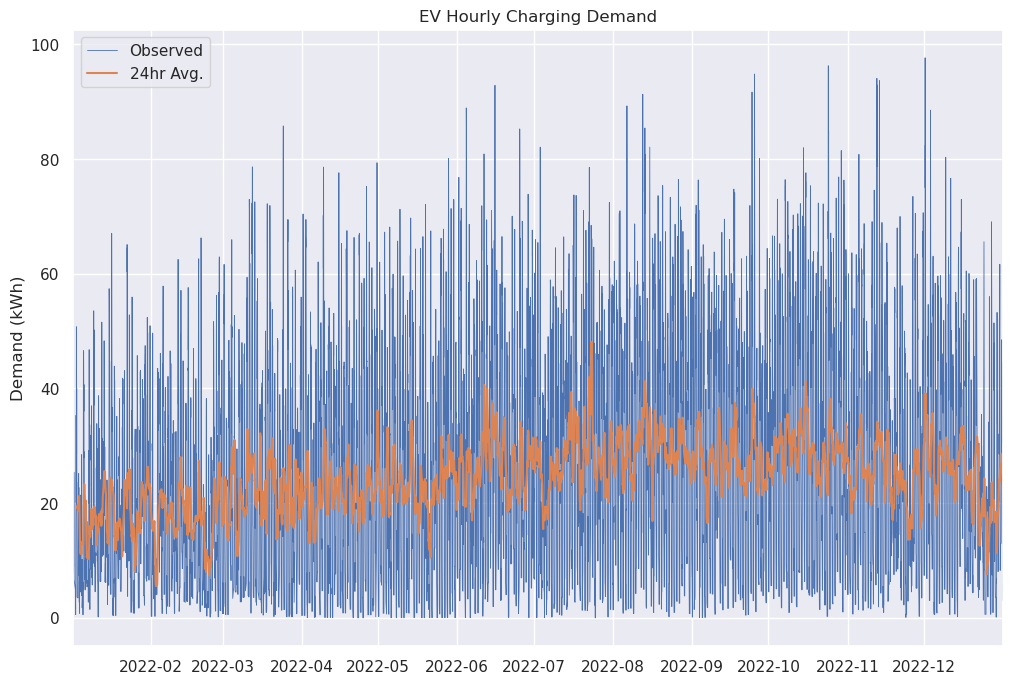

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X.index, X.kWh, linewidth=.6, label="Observed")

rolling_avg = X.kWh.rolling(24).mean()
ax.plot(X.index, rolling_avg, label="24hr Avg.")

ax.set_title("EV Hourly Charging Demand")
ax.set_ylabel("Demand (kWh)")
ax.set_xmargin(0)
ax.legend()

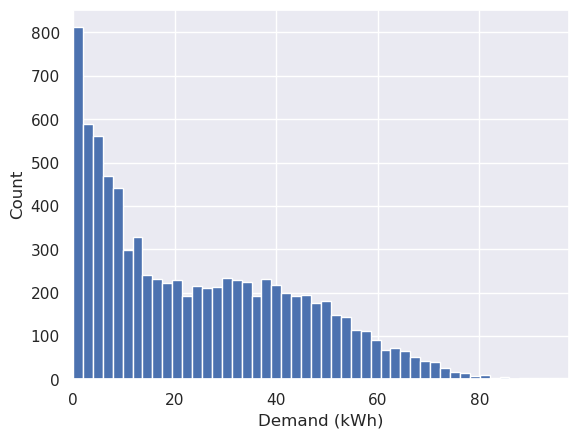

In [19]:
fig, ax = plt.subplots()

ax.hist(X.kWh, bins=50)

ax.set_ylabel("Count")
ax.set_xlabel("Demand (kWh)")
ax.set_xmargin(0)

In [20]:
len(years)

6

## Bayesian Hierarchical Model

In [21]:
coords = {
    "year": np.arange(len(years)),
    "hour": np.arange(24),
    "day": np.arange(7),
    "month": np.arange(1, 13)
}

In [22]:
with pm.Model(coords=coords) as model:
    hour = pm.MutableData("hour", X_train.hour.values)
    day = pm.MutableData("day", X_train.day.values)
    month = pm.MutableData("month", X_train.month.values - 1)
    temperature = pm.MutableData("temperature", X_train.temperature_std.values)
    is_holiday = pm.MutableData("is_holiday", X_train.is_holiday.values)
    kWh = pm.ConstantData("kWh", y_train.values)
    
    # Hyperpriors
    
    ## hour of day
    mu_beta = pm.Normal("mu_beta", 0, 1)
    sigma_beta = pm.Gamma("sigma_beta", 2, 2)

    ## day of week
    mu_gamma = pm.Normal("mu_gamma", 0, 1)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)

    ## month
    mu_eta = pm.Normal("mu_eta", 0, 1)
    sigma_eta = pm.Exponential("sigma_eta", 1)

    ## interaction of hour and day
    # mu_interaction = pm.Normal("mu_interaction", 0, 1)
    sigma_interaction = pm.Exponential("sigma_interaction", 1)

    ## holiday
    mu_rho = pm.Normal("mu_rho", 0, 1)
    sigma_rho = pm.Normal("sigma_rho", 0, 1)

    ## temperature
    mu_theta = pm.Normal("mu_theta", 0, 1)
    sigma_theta = pm.Exponential("sigma_theta", 1)

    # Priors
    
    ## hour of day
    beta = pm.Normal("beta", mu_beta, sigma_beta, dims="hour")

    ## day of week
    gamma = pm.Normal("gamma", mu_gamma, sigma_gamma, dims="day")

    ## month
    eta = pm.Normal("eta", mu_eta, sigma_eta, dims="month")

    ## holiday
    rho = pm.Normal("rho", mu_rho, sigma_rho, shape=2)
    
    ## temperature
    theta = pm.Normal("theta", mu_theta, sigma_theta, dims="hour")

    ## interaction of hour and day
    interaction = pm.Normal("interaction", 0, sigma_interaction, dims=("hour", "day"))

    # Likelihood
    mu = beta[hour] + gamma[day] + eta[month] + interaction[hour, day] + rho[is_holiday] + theta[hour] * temperature
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.TruncatedNormal("Y_obs", mu=mu, sigma=sigma, lower=0, observed=kWh, shape=hour.shape[0])

In [23]:
with model:
    idata = pm.sample(tune=2000, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_beta, sigma_beta, mu_gamma, sigma_gamma, mu_eta, sigma_eta, sigma_interaction, mu_rho, sigma_rho, mu_theta, sigma_theta, beta, gamma, eta, rho, theta, interaction, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 344 seconds.


array([[<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>],
       [<Axes: title={'center': 'mu_gamma'}>,
        <Axes: title={'center': 'mu_gamma'}>],
       [<Axes: title={'center': 'mu_eta'}>,
        <Axes: title={'center': 'mu_eta'}>],
       [<Axes: title={'center': 'mu_rho'}>,
        <Axes: title={'center': 'mu_rho'}>],
       [<Axes: title={'center': 'sigma_rho'}>,
        <Axes: title={'center': 'sigma_rho'}>],
       [<Axes: title={'center': 'mu_theta'}>,
        <Axes: title={'center': 'mu_theta'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'rho'}>, <Axes: title={'center': 'rho'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'interact

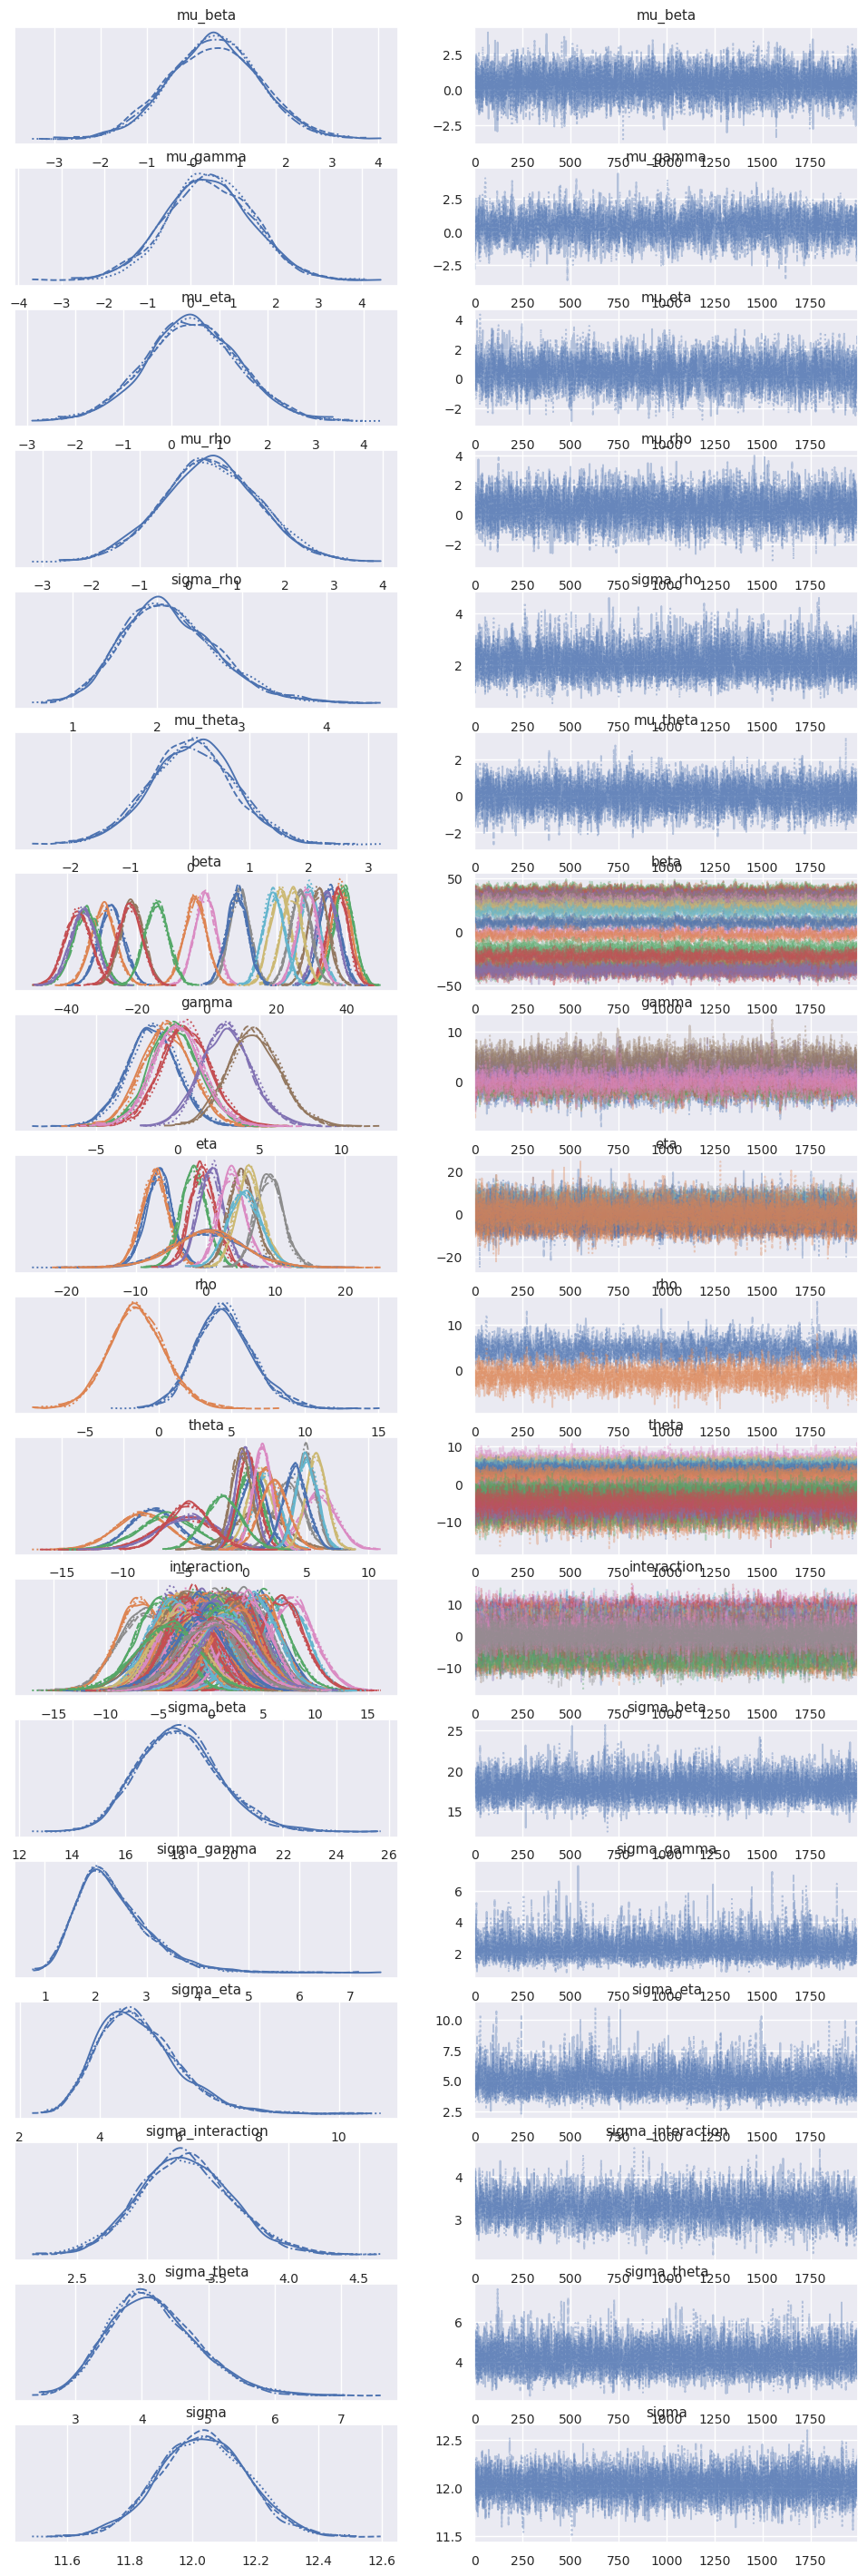

In [24]:
az.plot_trace(idata)

In [25]:
az.summary(idata, var_names="eta")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[1],-6.693,1.941,-10.399,-2.984,0.074,0.052,693.0,1512.0,1.0
eta[2],-7.289,1.956,-11.132,-3.781,0.075,0.053,691.0,1686.0,1.0
eta[3],-1.678,1.897,-5.147,2.050,0.073,0.052,685.0,1582.0,1.0
eta[4],-0.380,1.876,-3.758,3.257,0.073,0.052,667.0,1564.0,1.0
eta[5],0.797,1.875,-2.546,4.488,0.073,0.052,670.0,1267.0,1.0
eta[6],5.268,1.913,1.624,8.832,0.072,0.051,707.0,1468.0,1.0
eta[7],3.819,1.950,0.279,7.631,0.072,0.051,749.0,1534.0,1.0
eta[8],9.225,1.961,5.679,13.054,0.073,0.052,723.0,1537.0,1.0
eta[9],6.314,1.905,2.871,10.038,0.072,0.052,702.0,1429.0,1.0
eta[10],5.603,2.440,1.276,10.403,0.070,0.050,1229.0,2513.0,1.0


In [26]:
with model:
    pm.compute_log_likelihood(idata, extend_inferencedata=True)

In [27]:
az.loo(idata)

Computed from 8000 posterior samples and 6422 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -21992.57    78.89
p_loo      138.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     6422  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [28]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [Y_obs]


<Axes: xlabel='Y_obs / Y_obs'>

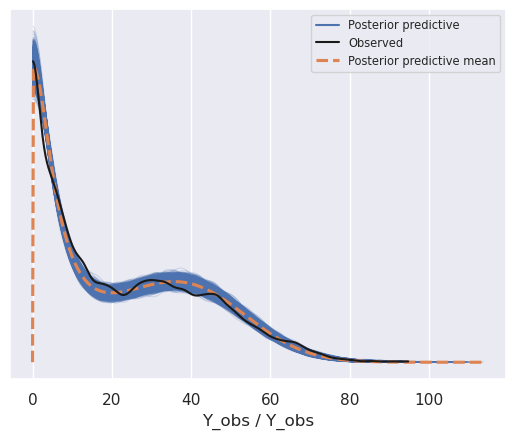

In [29]:
az.plot_ppc(idata)

In [30]:
Y_obs = idata.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse = np.sqrt(np.mean((Y_obs - y_train)**2))

print(f"RMSE (train): {rmse} kWh")

RMSE (train): 9.678838048249505 kWh


In [31]:
r2 = az.r2_score(y_train, Y_obs)

print(f"R^2 (train): {r2.values[0]}")

R^2 (train): 0.7504553138779751


Text(0, 0.5, 'Hour')

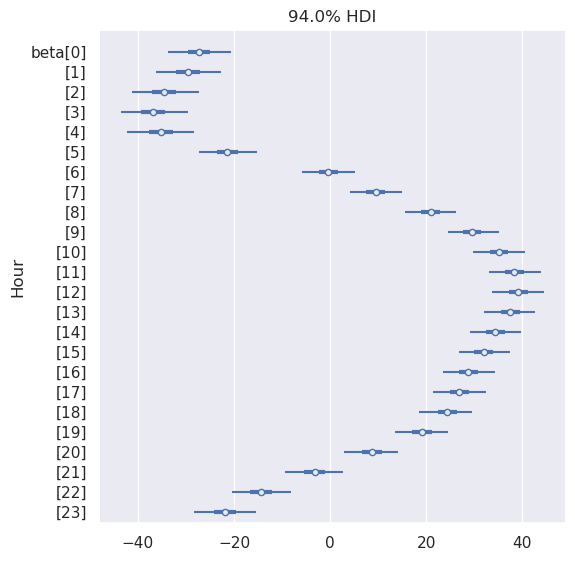

In [32]:
axes = az.plot_forest(idata, var_names=["beta"], combined=True)
axes[0].set_ylabel("Hour")

Text(0, 0.5, 'Day')

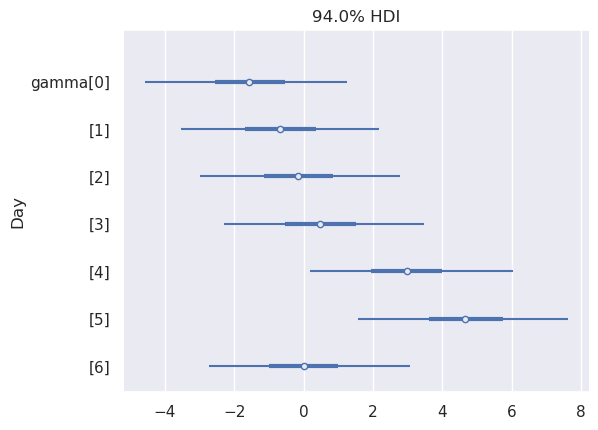

In [33]:
axes = az.plot_forest(idata, var_names=["gamma"], combined=True)
axes[0].set_ylabel("Day")

Text(0, 0.5, 'Holiday')

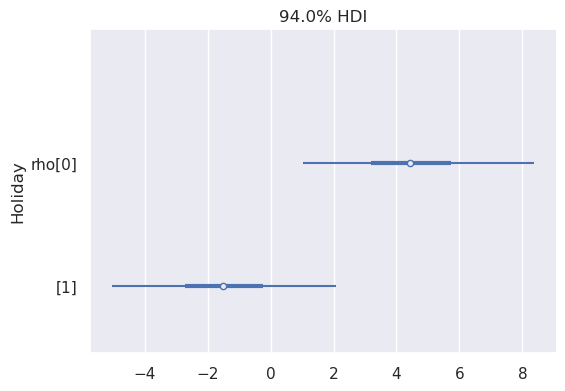

In [53]:
axes = az.plot_forest(idata, var_names=["rho"], combined=True)
axes[0].set_ylabel("Holiday")

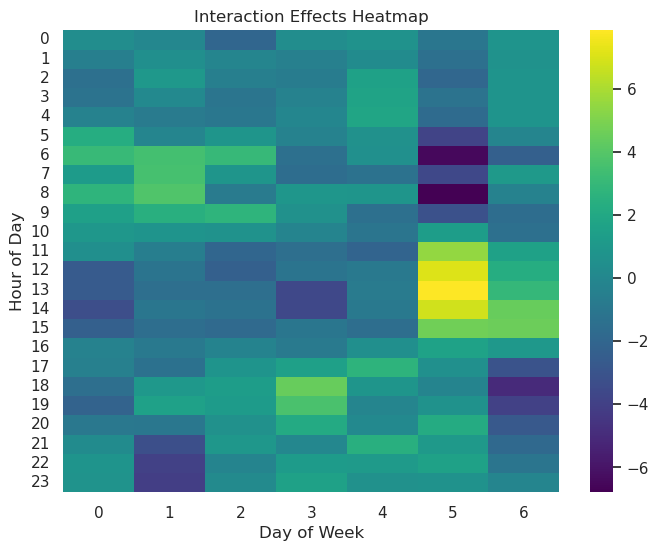

In [34]:
interaction_effects = idata.posterior['interaction'].mean(('chain', 'draw')).values

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(interaction_effects, cmap='viridis', ax=ax)

plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('Interaction Effects Heatmap')
plt.show()

Text(0, 0.5, 'Hour/Day')

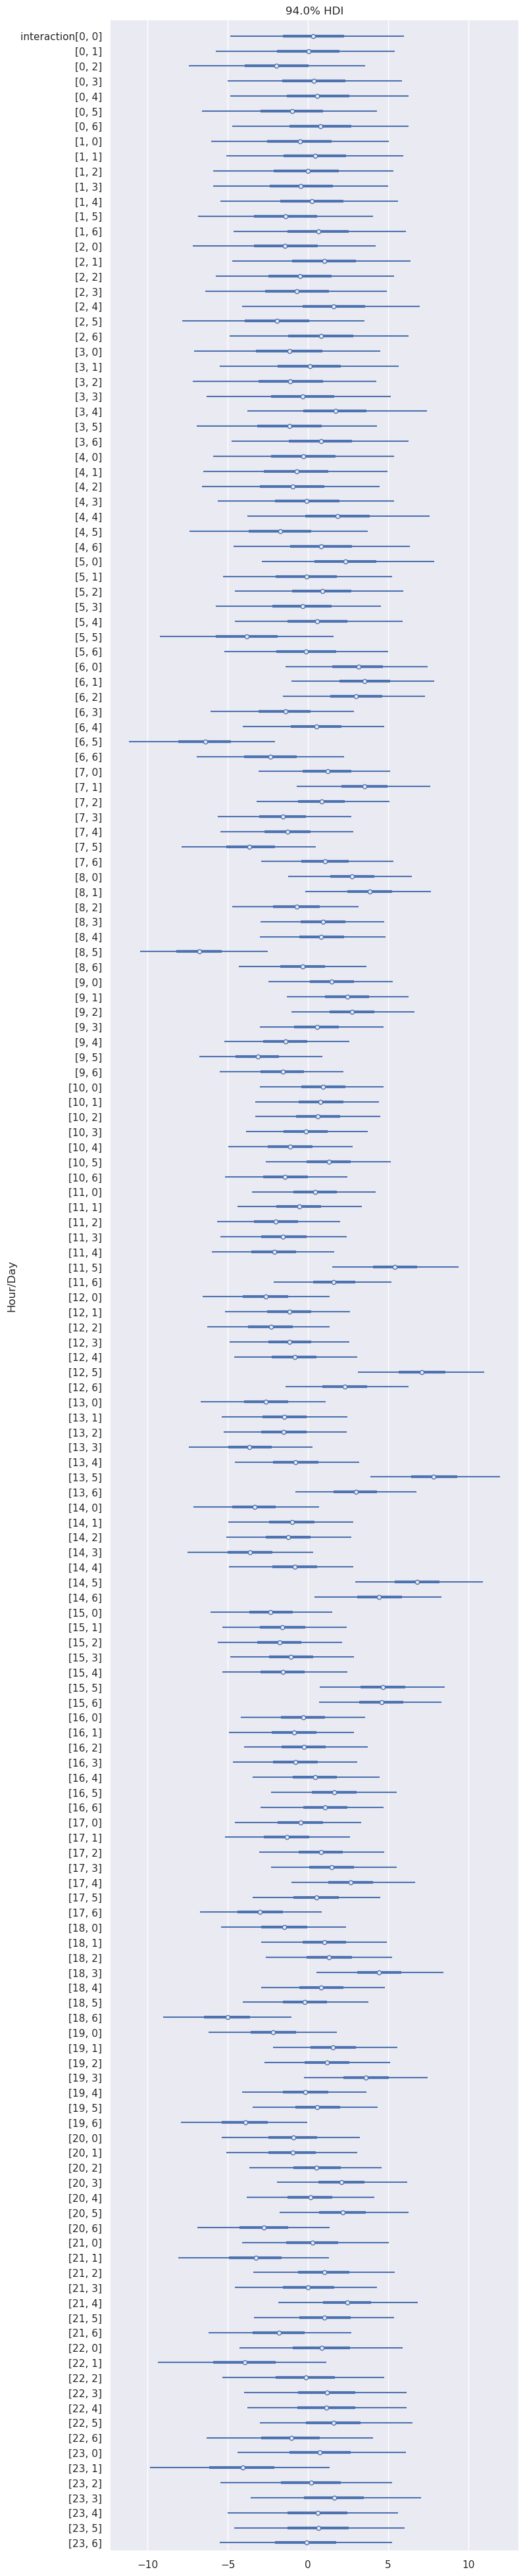

In [35]:
axes = az.plot_forest(idata, var_names=["interaction"], combined=True, figsize=(8, 50))
axes[0].set_ylabel("Hour/Day")

In [36]:
# make predictions on new data
with model:
    pm.set_data({"hour": X_test.hour, "day": X_test.day, "month": X_test.month - 1, "temperature": X_test.temperature_std, "is_holiday": X_test.is_holiday})
    post_idata = pm.sample_posterior_predictive(
        idata, random_seed=RANDOM_SEED
    )

Sampling: [Y_obs]


In [37]:
Y_obs_test = post_idata.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse_test = np.sqrt(np.mean((Y_obs_test - y_test)**2))

print(f"RMSE (test): {rmse_test} kWh")

RMSE (test): 11.299244012876459 kWh


In [38]:
r2_test_bhm = az.r2_score(y_test, Y_obs_test)

print(f"R^2 (test): {r2_test_bhm.values[0]}")

R^2 (test): 0.681534281160087


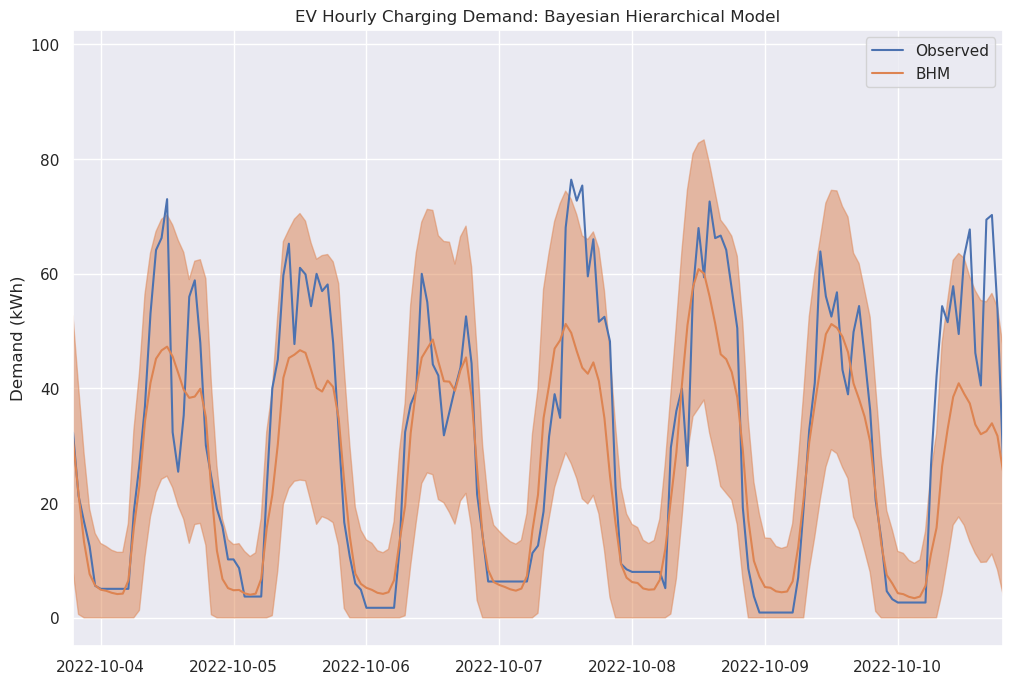

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X_test.index, y_test, label="Observed")
ax.plot(X_test.index, Y_obs_test, label="BHM")
az.plot_hdi(X_test.index, post_idata.posterior_predictive.Y_obs, smooth=False)

ax.set_xlim([X_test.index[0], X_test.index[24*7]])

ax.set_title("EV Hourly Charging Demand: Bayesian Hierarchical Model")
ax.set_ylabel("Demand (kWh)")
ax.set_xmargin(0)
ax.legend()

## Non-parametric

### Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [41]:
rf = RandomForestRegressor(oob_score=True)

In [42]:
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True)

In [43]:
rf.oob_score_

0.7518388616590002

In [44]:
r2_train_rf = rf.score(X_train, y_train)

print(f"R^2 (test): {r2_train_rf}")

R^2 (test): 0.9645584278903399


In [45]:
r2_test_rf = rf.score(X_test, y_test)

print(f"R^2 (test): {r2_test_rf}")

R^2 (test): 0.6117079065778281


In [46]:
y_pred_train = rf.predict(X_train)

rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print(f"RMSE (train):{rmse} kWh")

RMSE (train):3.6791528950159864 kWh


In [47]:
y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (test):{rmse} kWh")

RMSE (test):13.108399457392819 kWh


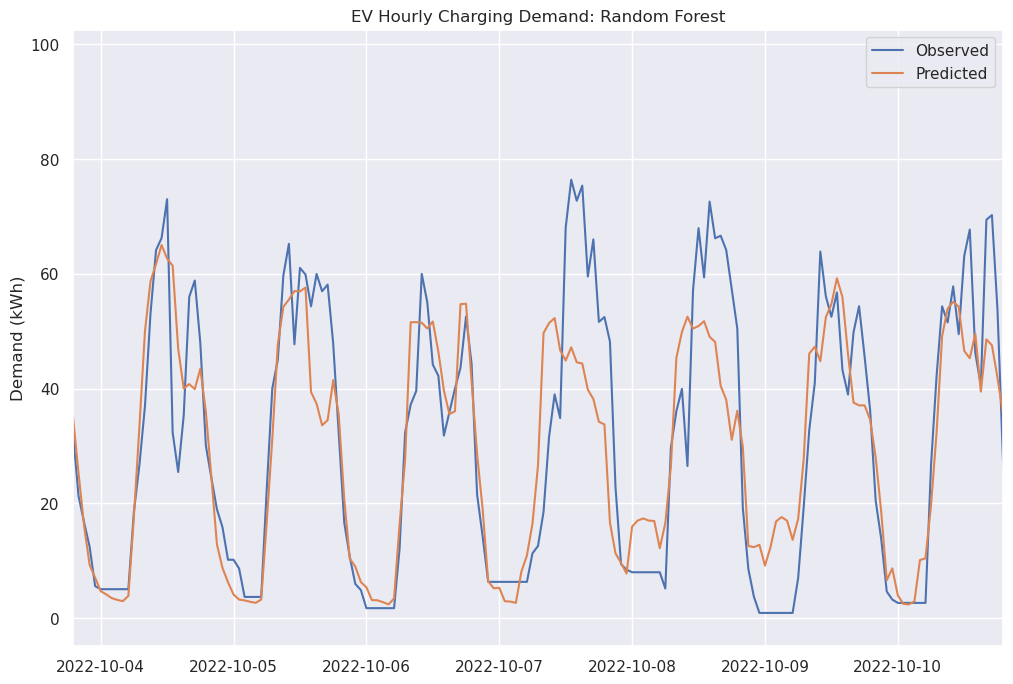

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))

sorted = np.argsort(X_test.index)

xt = X_test.sort_index()

ax.plot(xt.index, y_test.iloc[sorted], label="Observed")
ax.plot(xt.index, y_pred[sorted], label="Predicted")

ax.set_xlim([X_test.index[0], X_test.index[24*7]])

ax.set_title("EV Hourly Charging Demand: Random Forest")
ax.set_ylabel("Demand (kWh)")
ax.set_xmargin(0)

ax.legend()

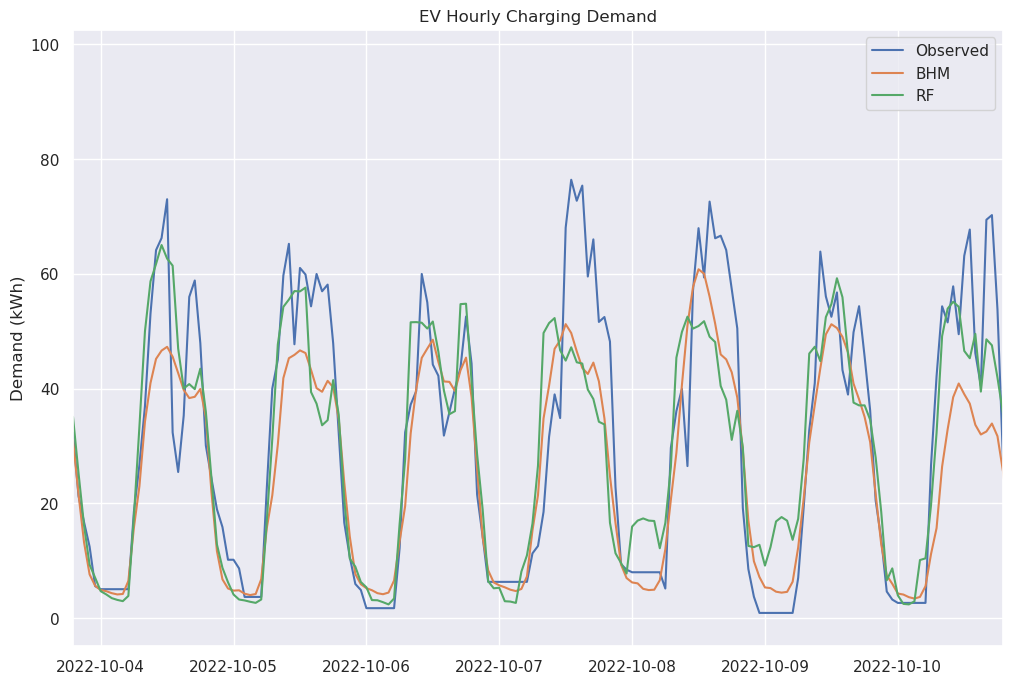

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X_test.index, y_test, label="Observed")
ax.plot(X_test.index, Y_obs_test, label="BHM")
ax.plot(xt.index, y_pred[sorted], label="RF")

ax.set_xlim([X_test.index[0], X_test.index[24*7]])

ax.set_title("EV Hourly Charging Demand")
ax.set_ylabel("Demand (kWh)")
ax.set_xmargin(0)
ax.legend()